In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import os

In [2]:
libri= torchaudio.datasets.LIBRISPEECH('./corpus', url='train-clean-100')

In [3]:
libri[0]

(tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]),
 16000,
 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',
 103,
 1240,
 0)

In [4]:
waveform, sample_rate, transcript, _, _, _ = libri[0]

In [5]:
Audio(waveform.numpy(), rate=sample_rate)

In [6]:
libri.get_metadata(0)

('train-clean-100/103/1240/103-1240-0000.flac',
 16000,
 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',
 103,
 1240,
 0)

In [7]:
waveform2, sample_rate2= torchaudio.load(os.path.join('./corpus/LibriSpeech/',libri.get_metadata(0)[0]))

In [8]:
waveform == waveform2

tensor([[True, True, True,  ..., True, True, True]])

In [9]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

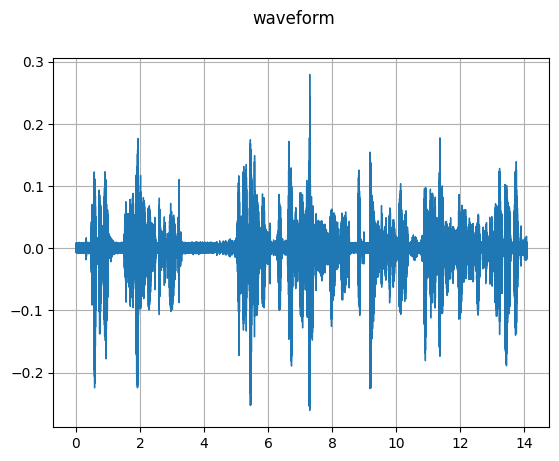

In [10]:
plot_waveform(waveform, sample_rate)

In [11]:
import torchaudio.transforms as T


class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=400,
        hop_length=160,
        n_mel=80,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = T.Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = T.Spectrogram(n_fft=n_fft, power=2)
        self.mel_scale = T.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

In [12]:
# Instantiate a pipeline
pipeline = MyPipeline()

# Perform the transform
features = pipeline(waveform)


In [13]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


In [14]:
features

tensor([[[3.2108e-02, 6.5080e-02, 7.8729e-02,  ..., 7.0321e-02,
          7.3948e-02, 6.5934e-02],
         [1.1623e-01, 2.3559e-01, 2.8500e-01,  ..., 2.5457e-01,
          2.6770e-01, 2.3869e-01],
         [1.9816e-01, 1.3863e-01, 1.8075e-01,  ..., 1.8145e-01,
          1.5895e-01, 1.6545e-01],
         ...,
         [6.0948e-05, 5.8731e-05, 9.3804e-05,  ..., 3.3571e-04,
          6.1130e-04, 4.3818e-04],
         [7.0252e-05, 4.0889e-05, 6.9521e-05,  ..., 9.8588e-04,
          3.2309e-04, 2.0722e-04],
         [3.9896e-05, 4.3424e-05, 7.6945e-05,  ..., 3.5739e-04,
          2.5007e-04, 1.0518e-04]]])

In [15]:
features.shape

torch.Size([1, 80, 1127])

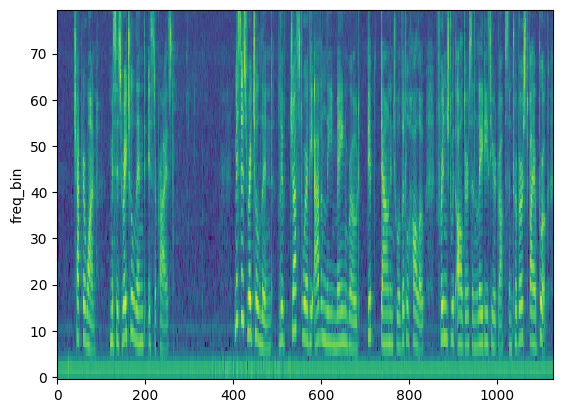

In [16]:
plot_spectrogram(features[0])

In [17]:
class MyPipeline2(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=400,
        hop_length=160,
        n_mel=80,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = T.Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = T.Spectrogram(n_fft=n_fft, power=2)
        self.spec_aug = torch.nn.Sequential(
            T.TimeStretch(stretch_factor, fixed_rate=True),
            T.FrequencyMasking(freq_mask_param=80),
            T.TimeMasking(time_mask_param=80),
        )
        self.mel_scale = T.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)
        
        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

In [21]:
# Instantiate a pipeline
pipeline2 = MyPipeline2()

# Perform the transform
features2 = pipeline2(waveform)

In [22]:
features2.shape

torch.Size([1, 80, 1127])

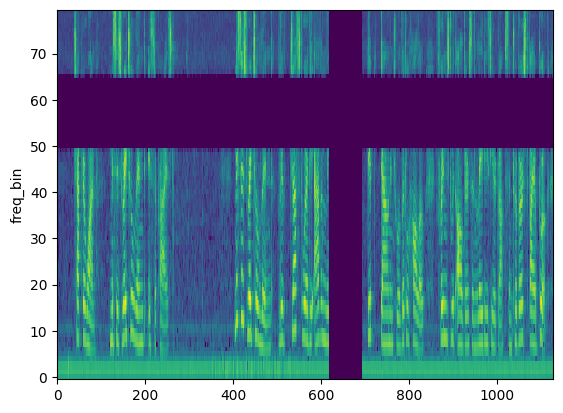

In [23]:
plot_spectrogram(features2[0])